**Inhibtion Factor**

Inhibition Factor: 0.00 | Test Accuracy: 81.29%
Inhibition Factor: 0.10 | Test Accuracy: 83.39%
Inhibition Factor: 0.20 | Test Accuracy: 84.85%
Inhibition Factor: 0.30 | Test Accuracy: 76.65%
Inhibition Factor: 0.40 | Test Accuracy: 55.87%
Inhibition Factor: 0.50 | Test Accuracy: 41.79%
Inhibition Factor: 0.60 | Test Accuracy: 23.14%
Inhibition Factor: 0.70 | Test Accuracy: 14.18%
Inhibition Factor: 0.80 | Test Accuracy: 12.10%
Inhibition Factor: 0.90 | Test Accuracy: 9.38%
Inhibition Factor: 1.00 | Test Accuracy: 8.20%
Inhibition Factor: 1.10 | Test Accuracy: 8.74%
Inhibition Factor: 1.20 | Test Accuracy: 5.42%
Inhibition Factor: 1.30 | Test Accuracy: 9.85%
Inhibition Factor: 1.40 | Test Accuracy: 7.56%
Inhibition Factor: 1.50 | Test Accuracy: 5.26%
Inhibition Factor: 1.60 | Test Accuracy: 9.33%
Inhibition Factor: 1.70 | Test Accuracy: 8.41%
Inhibition Factor: 1.80 | Test Accuracy: 10.16%
Inhibition Factor: 1.90 | Test Accuracy: 11.75%
Inhibition Factor: 2.00 | Test Accuracy: 8.12%
In

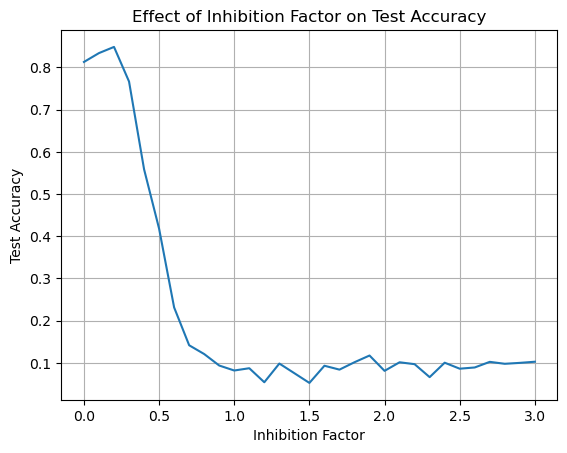

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# 1. Data Preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

# 2. KCNet Implementation
def generate_sparse_projection(input_dim, hidden_dim, connections_per_hidden):
    """
    Generates a sparse binary projection matrix.
    """
    projection = torch.zeros(hidden_dim, input_dim)
    for i in range(hidden_dim):
        selected_indices = torch.randperm(input_dim)[:connections_per_hidden]
        projection[i, selected_indices] = 1
    return projection

class KCNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, connections_per_hidden):
        """
        Initializes the KCNet model.
        """
        super(KCNet, self).__init__()
        self.projection_matrix = generate_sparse_projection(input_dim, hidden_dim, connections_per_hidden)
        self.output_weights = None  # To be trained during ridge regression
        self.hidden_dim = hidden_dim

    def forward(self, x):
        """
        Forward pass for KCNet.
        """
        # Step 1: Random projection
        hidden_activations = torch.matmul(x, self.projection_matrix.T)
        
        # Step 2: Global inhibition and ReLU
        mean_activation = hidden_activations.mean(dim=1, keepdim=True)
        inhibited_activations = hidden_activations - self.inhibition_factor * mean_activation
        sparse_output = torch.relu(inhibited_activations)
        
        # Step 3: Linear output layer
        output = sparse_output @ self.output_weights
        return output

    def train_output_layer(self, hidden_layer_outputs, targets, lambda_reg=0.01):
        """
        Trains the output layer weights using ridge regression.
        """
        H_T = hidden_layer_outputs.T
        regularization = lambda_reg * torch.eye(H_T.shape[0])

        try:
            ridge_matrix = torch.inverse(H_T @ hidden_layer_outputs + regularization)
            self.output_weights = ridge_matrix @ H_T @ targets
        except Exception as e:
            print(f"Error during matrix inversion or multiplication: {e}")
            # Fallback or additional debugging

# 3. Training Output Weights
def train_kcnet(model, train_loader, lambda_reg=0.1):
    """
    Trains the KCNet's output weights using ridge regression.
    """
    all_hidden_outputs = []
    all_targets = []

    # Collect hidden layer outputs and targets
    for data, target in train_loader:
        data = data.view(data.size(0), -1)  # Flatten images
        hidden_activations = torch.relu(data @ model.projection_matrix.T)
        all_hidden_outputs.append(hidden_activations)
        all_targets.append(torch.nn.functional.one_hot(target, num_classes=output_dim).float())

    # Combine all batches
    hidden_outputs = torch.cat(all_hidden_outputs, dim=0)
    targets = torch.cat(all_targets, dim=0)

    # Train output weights
    model.train_output_layer(hidden_outputs, targets, lambda_reg)

# 4. Evaluation
def evaluate_kcnet(model, data_loader):
    """
    Evaluates the KCNet model on a dataset.
    """
    all_predictions = []
    all_labels = []

    for data, target in data_loader:
        data = data.view(data.size(0), -1)  # Flatten images
        output = model(data)
        predictions = output.argmax(dim=1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    return accuracy

# 5. Testing Different Inhibition Factors
def test_inhibition_factors():
    # Range of inhibition factors to test
    inhibition_factors = [i * 0.1 for i in range(31)]  # from 0.0 to 3.0 with 0.1 increments
    accuracies = []

    for inhibition_factor in inhibition_factors:
        # Initialize KCNet with the given inhibition factor
        kcnet = KCNet(input_dim=28*28, hidden_dim=6500, output_dim=10, connections_per_hidden=7)
        kcnet.inhibition_factor = inhibition_factor

        # Train output layer
        train_kcnet(kcnet, train_loader, lambda_reg=0.1)

        # Evaluate on test set
        test_accuracy = evaluate_kcnet(kcnet, test_loader)
        accuracies.append(test_accuracy)

        # Print current inhibition factor and corresponding accuracy
        print(f"Inhibition Factor: {inhibition_factor:.2f} | Test Accuracy: {test_accuracy * 100:.2f}%")

    # Plotting
    plt.plot(inhibition_factors, accuracies)
    plt.xlabel('Inhibition Factor')
    plt.ylabel('Test Accuracy')
    plt.title('Effect of Inhibition Factor on Test Accuracy')
    plt.grid(True)
    plt.show()

# 6. Model Training and Evaluation
input_dim = 28 * 28  # Flattened MNIST images
hidden_dim = 6500    # Hidden neurons (Kenyon cells)
output_dim = 10      # Number of classes (digits 0-9)
connections_per_hidden = 7  # Sparse connections

# Run the experiment to test a range of inhibition factors
test_inhibition_factors()


Effect of Ridge lambda regression: Beta = (H^T H + lambda * I)^(-1) H^T Y

Hidden layer outputs shape: torch.Size([60000, 6500])
Targets shape: torch.Size([60000, 10])
H_T shape: torch.Size([6500, 60000])
Regularization shape: torch.Size([6500, 6500])
Test Accuracy with lambda regularization0.01: 83.64%
Hidden layer outputs shape: torch.Size([60000, 6500])
Targets shape: torch.Size([60000, 10])
H_T shape: torch.Size([6500, 60000])
Regularization shape: torch.Size([6500, 6500])
Test Accuracy with lambda regularization0.02: 83.69%
Hidden layer outputs shape: torch.Size([60000, 6500])
Targets shape: torch.Size([60000, 10])
H_T shape: torch.Size([6500, 60000])
Regularization shape: torch.Size([6500, 6500])
Test Accuracy with lambda regularization0.03: 83.78%
Hidden layer outputs shape: torch.Size([60000, 6500])
Targets shape: torch.Size([60000, 10])
H_T shape: torch.Size([6500, 60000])
Regularization shape: torch.Size([6500, 6500])
Test Accuracy with lambda regularization0.04: 83.77%
Hidden layer outputs shape: torch.Size([60000, 6500])
Targets shape: torch.Size(

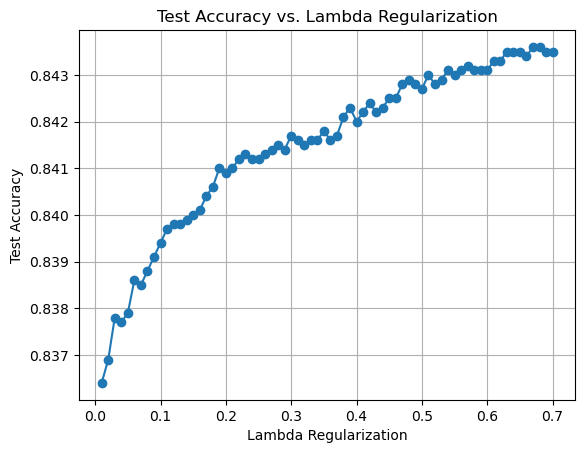

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score

# 1. Data Preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

# 2. KCNet Implementation
def generate_sparse_projection(input_dim, hidden_dim, connections_per_hidden):
    """
    Generates a sparse binary projection matrix.
    """
    projection = torch.zeros(hidden_dim, input_dim)
    for i in range(hidden_dim):
        selected_indices = torch.randperm(input_dim)[:connections_per_hidden]
        projection[i, selected_indices] = 1
    return projection

class KCNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, connections_per_hidden):
        """
        Initializes the KCNet model.
        """
        super(KCNet, self).__init__()
        self.projection_matrix = generate_sparse_projection(input_dim, hidden_dim, connections_per_hidden)
        self.output_weights = None  # To be trained during ridge regression
        self.hidden_dim = hidden_dim

    def forward(self, x):
        """
        Forward pass for KCNet.
        """
        # Step 1: Random projection
        hidden_activations = torch.matmul(x, self.projection_matrix.T)
        
        # Step 2: Global inhibition and ReLU
        mean_activation = hidden_activations.mean(dim=1, keepdim=True)
        inhibited_activations = hidden_activations - 0.1 * mean_activation
        sparse_output = torch.relu(inhibited_activations)
        
        # Step 3: Linear output layer
        output = sparse_output @ self.output_weights
        return output

    def train_output_layer(self, hidden_layer_outputs, targets, lambda_reg=0.01):
        """
        Trains the output layer weights using ridge regression.
        """
        print(f"Hidden layer outputs shape: {hidden_layer_outputs.shape}")
        print(f"Targets shape: {targets.shape}")
        
        # Ridge regression: Beta = (H^T H + lambda * I)^(-1) H^T Y
        H_T = hidden_layer_outputs.T
        print(f"H_T shape: {H_T.shape}")
        
        regularization = lambda_reg * torch.eye(H_T.shape[0])
        print(f"Regularization shape: {regularization.shape}")
        
        # Try to compute this part safely
        try:
            ridge_matrix = torch.inverse(H_T @ hidden_layer_outputs + regularization)
            self.output_weights = ridge_matrix @ H_T @ targets
        except Exception as e:
            print(f"Error during matrix inversion or multiplication: {e}")
            # Fallback or additional debugging



# 3. Training Output Weights
def train_kcnet(model, train_loader, lambda_reg=0.1):
    """
    Trains the KCNet's output weights using ridge regression.
    """
    all_hidden_outputs = []
    all_targets = []

    # Collect hidden layer outputs and targets
    for data, target in train_loader:
        data = data.view(data.size(0), -1)  # Flatten images
        hidden_activations = torch.relu(data @ model.projection_matrix.T)
        all_hidden_outputs.append(hidden_activations)
        all_targets.append(torch.nn.functional.one_hot(target, num_classes=output_dim).float())

    # Combine all batches
    hidden_outputs = torch.cat(all_hidden_outputs, dim=0)
    targets = torch.cat(all_targets, dim=0)

    # Train output weights
    model.train_output_layer(hidden_outputs, targets, lambda_reg)

# 4. Evaluation
def evaluate_kcnet(model, data_loader):
    """
    Evaluates the KCNet model on a dataset.
    """
    all_predictions = []
    all_labels = []

    for data, target in data_loader:
        data = data.view(data.size(0), -1)  # Flatten images
        output = model(data)
        predictions = output.argmax(dim=1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    return accuracy

# 5. Model Training and Evaluation
# Define KCNet parameters
input_dim = 28 * 28  # Flattened MNIST images
hidden_dim = 6500    # Hidden neurons (Kenyon cells)
output_dim = 10      # Number of classes (digits 0-9)
connections_per_hidden = 7  # Sparse connections

# Initialize KCNet
kcnet = KCNet(input_dim, hidden_dim, output_dim, connections_per_hidden)
lambda_values = np.arange(0.01, 0.71, 0.01)
accuracies = []
for lambda_reg in lambda_values:
    # Train output layer
    train_kcnet(kcnet, train_loader, lambda_reg)
    test_accuracy = evaluate_kcnet(kcnet, test_loader)
    accuracies.append(test_accuracy)
    print(f"Test Accuracy with lambda regularization{lambda_reg}: {test_accuracy * 100:.2f}%")

import matplotlib.pyplot as plt
# 7. Plotting Accuracy vs. Lambda Regularization
plt.plot(lambda_values, accuracies, marker='o')
plt.xlabel('Lambda Regularization')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Lambda Regularization')
plt.grid(True)
# Save the plot with high quality (300 dpi)
plt.savefig('Lambda.png', dpi=300)
plt.show()
    
# # Train output layer
# train_kcnet(kcnet, train_loader, lambda_reg=0.1)

# # Evaluate on test set
# test_accuracy = evaluate_kcnet(kcnet, test_loader)
# print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score

# 1. Data Preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

# 2. KCNet Implementation
def generate_sparse_projection(input_dim, hidden_dim, connections_per_hidden):
    """
    Generates a sparse binary projection matrix.
    """
    projection = torch.zeros(hidden_dim, input_dim)
    for i in range(hidden_dim):
        selected_indices = torch.randperm(input_dim)[:connections_per_hidden]
        projection[i, selected_indices] = 1
    return projection

class KCNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, connections_per_hidden):
        """
        Initializes the KCNet model.
        """
        super(KCNet, self).__init__()
        self.projection_matrix = generate_sparse_projection(input_dim, hidden_dim, connections_per_hidden)
        self.output_weights = None  # To be trained during ridge regression
        self.hidden_dim = hidden_dim

    def forward(self, x):
        """
        Forward pass for KCNet.
        """
        # Step 1: Random projection
        hidden_activations = torch.matmul(x, self.projection_matrix.T)
        
        # Step 2: Global inhibition and ReLU
        mean_activation = hidden_activations.mean(dim=1, keepdim=True)
        inhibited_activations = hidden_activations - 0.1 * mean_activation
        sparse_output = torch.relu(inhibited_activations)
        
        # Step 3: Linear output layer
        output = sparse_output @ self.output_weights
        return output

    def train_output_layer(self, hidden_layer_outputs, targets, lambda_reg=0.01):
        """
        Trains the output layer weights using ridge regression.
        """
        print(f"Hidden layer outputs shape: {hidden_layer_outputs.shape}")
        print(f"Targets shape: {targets.shape}")
        
        # Ridge regression: Beta = (H^T H + lambda * I)^(-1) H^T Y
        H_T = hidden_layer_outputs.T
        print(f"H_T shape: {H_T.shape}")
        
        regularization = lambda_reg * torch.eye(H_T.shape[0])
        print(f"Regularization shape: {regularization.shape}")
        
        # Try to compute this part safely
        try:
            ridge_matrix = torch.inverse(H_T @ hidden_layer_outputs + regularization)
            self.output_weights = ridge_matrix @ H_T @ targets
        except Exception as e:
            print(f"Error during matrix inversion or multiplication: {e}")
            # Fallback or additional debugging



# 3. Training Output Weights
def train_kcnet(model, train_loader, lambda_reg=0.1):
    """
    Trains the KCNet's output weights using ridge regression.
    """
    all_hidden_outputs = []
    all_targets = []

    # Collect hidden layer outputs and targets
    for data, target in train_loader:
        data = data.view(data.size(0), -1)  # Flatten images
        hidden_activations = torch.relu(data @ model.projection_matrix.T)
        all_hidden_outputs.append(hidden_activations)
        all_targets.append(torch.nn.functional.one_hot(target, num_classes=output_dim).float())

    # Combine all batches
    hidden_outputs = torch.cat(all_hidden_outputs, dim=0)
    targets = torch.cat(all_targets, dim=0)

    # Train output weights
    model.train_output_layer(hidden_outputs, targets, lambda_reg)

# 4. Evaluation
def evaluate_kcnet(model, data_loader):
    """
    Evaluates the KCNet model on a dataset.
    """
    all_predictions = []
    all_labels = []

    for data, target in data_loader:
        data = data.view(data.size(0), -1)  # Flatten images
        output = model(data)
        predictions = output.argmax(dim=1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    return accuracy

# 5. Model Training and Evaluation
# Define KCNet parameters
input_dim = 28 * 28  # Flattened MNIST images
hidden_dim = 6500    # Hidden neurons (Kenyon cells)
output_dim = 10      # Number of classes (digits 0-9)
connections_per_hidden = 7  # Sparse connections

# Initialize KCNet
kcnet = KCNet(input_dim, hidden_dim, output_dim, connections_per_hidden)
n_runs = 5
results = []
for run in range(n_runs):
    # Train output layer
    train_kcnet(kcnet, train_loader, lambda_reg=0.7)
    test_accuracy = evaluate_kcnet(kcnet, test_loader)
    print(f"Test Accuracy run {run} : {test_accuracy * 100:.2f}%")
    results.append(test_accuracy)

# Calculate average and standard deviation
average_result = np.mean(results)
std_deviation = np.std(results)

# Print results
print(f"Average Accuracy: {average_result:.4f} ± {std_deviation:.4f}")
    


Hidden layer outputs shape: torch.Size([60000, 6500])
Targets shape: torch.Size([60000, 10])
H_T shape: torch.Size([6500, 60000])
Regularization shape: torch.Size([6500, 6500])
Test Accuracy run 0 : 84.90%
Hidden layer outputs shape: torch.Size([60000, 6500])
Targets shape: torch.Size([60000, 10])
H_T shape: torch.Size([6500, 60000])
Regularization shape: torch.Size([6500, 6500])
Test Accuracy run 1 : 84.90%
Hidden layer outputs shape: torch.Size([60000, 6500])
Targets shape: torch.Size([60000, 10])
H_T shape: torch.Size([6500, 60000])
Regularization shape: torch.Size([6500, 6500])
Test Accuracy run 2 : 84.89%
Hidden layer outputs shape: torch.Size([60000, 6500])
Targets shape: torch.Size([60000, 10])
H_T shape: torch.Size([6500, 60000])
Regularization shape: torch.Size([6500, 6500])
Test Accuracy run 3 : 84.89%
Hidden layer outputs shape: torch.Size([60000, 6500])
Targets shape: torch.Size([60000, 10])
H_T shape: torch.Size([6500, 60000])
Regularization shape: torch.Size([6500, 6500])